# AMG - Population change analysis

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np
from scipy import stats
from scipy.stats import gaussian_kde

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Gather data

### Population change data and time to masive public transport stop

In [2]:
c = 'Guadalajara'
res = 8

In [3]:
grl_dir = '/home/edgaregurrola/SIG/ObsCds/Proyectos/Vivienda_Deshabitada/'
hex_pop = gpd.read_file(grl_dir+'Info_Sociodemografica/Analisis/Block_Census/Guadalajara_Census_10_20_BlockAnalysis_res8.geojson', driver='GeoJSON')
hex_tp = gpd.read_file(grl_dir+'/Medio_Urbano/Transporte_Publico/hex_t_masivo_GDL_V2.geojson', driver='GeoJSON')

In [4]:
print(hex_pop.shape)
hex_pop.head(2)

(1160, 430)


,hex_id_8,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,p_3ymas_f,p_3ymas_m,...,Z_RTViv_10_20,R_VivHab_20,R_VivDes_20,Z_RVivHab_20,R_VivHab_10,Z_RVivHab_10,Chng_RVivHab_10,R_TVivDes_10_20,DensPob_10_20,geometry
0,8849aa2d99fffff,848.0,427.0,421.0,46.0,16.0,24.0,794.0,403.0,391.0,...,None,0.716981,0.160377,-0.281484,0.0,None,0.716981,None,-2.276028,"POLYGON ((-103.32340 20.57940, -103.31887 20.5..."
1,88498c95cbfffff,7259.0,3697.0,3557.0,310.0,149.0,128.0,6899.0,3510.0,3389.0,...,None,0.839589,0.083110,0.391420,0.0,None,0.839589,None,-4.227884,"POLYGON ((-103.29386 20.71601, -103.28932 20.7..."


In [5]:
print(hex_tp.shape)
hex_tp.head(2)

(4095, 4)


,hex_id_8,CVEGEO,time_transporte_masivo_V2,geometry
0,8849abc91bfffff,14002,0.000000,"POLYGON ((-103.60989 20.39686, -103.61044 20.4..."
1,8849abc953fffff,14002,617.958757,"POLYGON ((-103.61277 20.37822, -103.60824 20.3..."


In [6]:
idx = hex_tp.time_transporte_masivo_V2>0
hex_tp = hex_tp[idx].copy()

In [7]:
hex_pop = hex_pop[['hex_id_8','T_Pob_10_20','T_Viv_10_20','R_VivDes_20']].copy()

<AxesSubplot:>

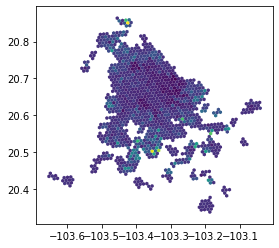

In [8]:
hex_merge = hex_tp.merge(hex_pop, on='hex_id_8')
hex_merge.plot('T_Pob_10_20')

<AxesSubplot:>

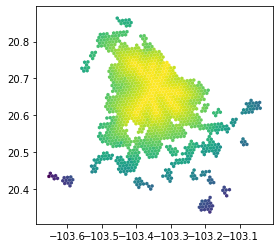

In [9]:
hex_merge.plot('time_transporte_masivo_V2', 'viridis_r')

## Filter data

### Less than 30 min vs More than 30 min

In [10]:
sample = 50
gdf_near_tp = hex_merge[hex_merge.time_transporte_masivo_V2<=30].sample(n=sample)
gdf_far_tp = hex_merge[hex_merge.time_transporte_masivo_V2>30].sample(n=sample)

## Analyzing means

In [11]:
print("Promedio de cambio de población por distancia a transporte público masivo")
print(f"Menos de 30 minutos: {gdf_near_tp.T_Pob_10_20.mean()} personas")
print(f"Más de 30 minutos: {gdf_far_tp.T_Pob_10_20.mean()} personas")

Promedio de cambio de población por distancia a transporte público masivo
Menos de 30 minutos: -338.08 personas
Más de 30 minutos: 553.36 personas


## Boxplot

In [12]:
box_plot_tp_analysis = gdf_near_tp.copy()
box_plot_tp_analysis['distance_tp'] = 'Menos de 30 minutos'
box_plot_tp_analysis = box_plot_tp_analysis.append(gdf_far_tp)
idx = box_plot_tp_analysis['distance_tp'].isna()
box_plot_tp_analysis.loc[idx, 'distance_tp'] = 'Más de 30 minutos'

Text(0, 0.5, 'Cambio en la población (2010 vs 2020)')

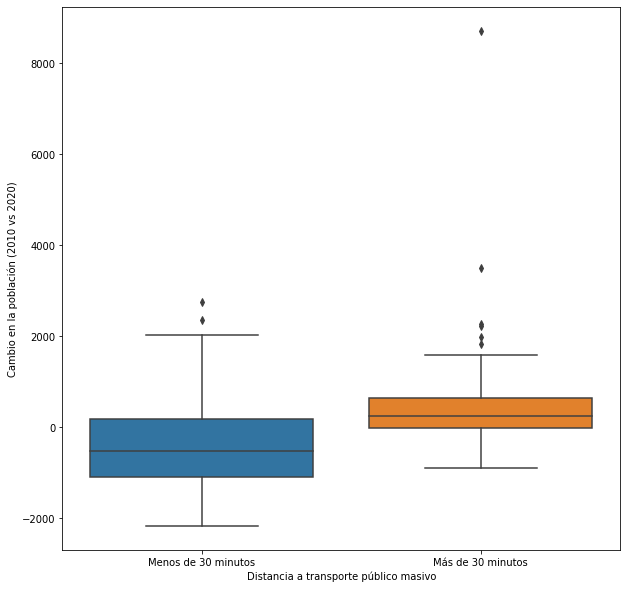

In [13]:
gdf_nearfig, ax = plt.subplots(figsize=(10,10))

x = np.array(box_plot_tp_analysis.distance_tp)
y = np.array(box_plot_tp_analysis.T_Pob_10_20)

sns.boxplot(x=x , y=y, ax=ax)

plt.xlabel('Distancia a transporte público masivo')
plt.ylabel('Cambio en la población (2010 vs 2020)')

## t-test

In [14]:
stats.ttest_ind(gdf_near_tp.T_Pob_10_20, gdf_far_tp.T_Pob_10_20)

Ttest_indResult(statistic=-3.3876086393866274, pvalue=0.0010163731231046173)

## Inner periférico - near vs far to public transport

In [15]:
hex_peri = gpd.read_file(grl_dir+'/Medio_Urbano/Vias_Transporte/AMG_HexRes8_Periferico_GCS_OC22_v1.geojson', driver='GeoJSON')
print(hex_peri.shape)
hex_peri.head(2)

(1160, 4)


,fid,hex_id_8,Periferico,geometry
0,1,8849aa2d99fffff,1,"POLYGON ((-103.32340 20.57940, -103.31887 20.5..."
1,2,88498c95cbfffff,0,"POLYGON ((-103.29386 20.71601, -103.28932 20.7..."


<AxesSubplot:>

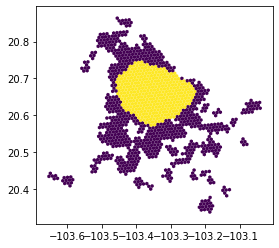

In [16]:
hex_merge_peri = hex_merge.merge(hex_peri[['hex_id_8','Periferico']], on='hex_id_8')
hex_merge_peri.plot('Periferico')

In [17]:
sample = 50
gdf_near_tp = hex_merge_peri[(hex_merge_peri.time_transporte_masivo_V2<=30)&
                       (hex_merge_peri.Periferico==1)].sample(n=sample)
gdf_far_tp = hex_merge_peri[(hex_merge_peri.time_transporte_masivo_V2>30)&
                       (hex_merge_peri.Periferico==1)].sample(n=sample)

In [18]:
print("Promedio de cambio de población por distancia a transporte público masivo")
print(f"Menos de 30 minutos: {gdf_near_tp.T_Pob_10_20.mean()} personas")
print(f"Más de 30 minutos: {gdf_far_tp.T_Pob_10_20.mean()} personas")

Promedio de cambio de población por distancia a transporte público masivo
Menos de 30 minutos: -763.12 personas
Más de 30 minutos: 93.12 personas


In [19]:
box_plot_tp_analysis = gdf_near_tp.copy()
box_plot_tp_analysis['distance_tp'] = 'Menos de 30 minutos'
box_plot_tp_analysis = box_plot_tp_analysis.append(gdf_far_tp)
idx = box_plot_tp_analysis['distance_tp'].isna()
box_plot_tp_analysis.loc[idx, 'distance_tp'] = 'Más de 30 minutos'

Text(0, 0.5, 'Cambio en la población (2010 vs 2020)')

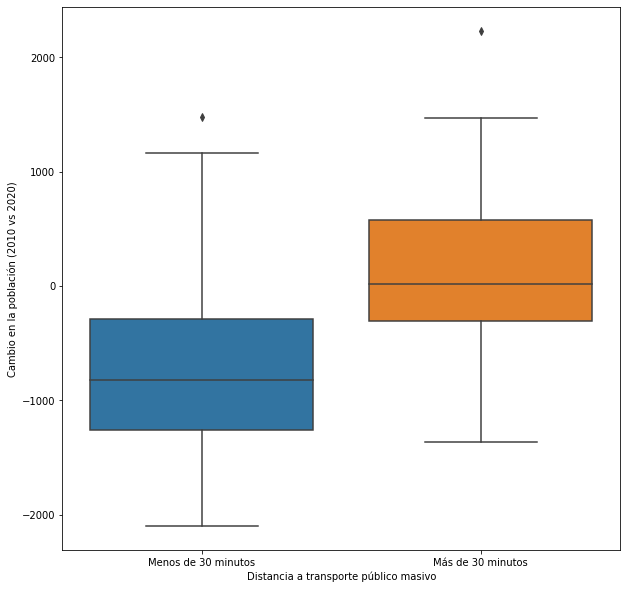

In [20]:
gdf_nearfig, ax = plt.subplots(figsize=(10,10))

x = np.array(box_plot_tp_analysis.distance_tp)
y = np.array(box_plot_tp_analysis.T_Pob_10_20)

sns.boxplot(x=x , y=y, ax=ax)

plt.xlabel('Distancia a transporte público masivo')
plt.ylabel('Cambio en la población (2010 vs 2020)')

In [21]:
stats.ttest_ind(gdf_near_tp.T_Pob_10_20, gdf_far_tp.T_Pob_10_20)

Ttest_indResult(statistic=-5.657873085341411, pvalue=1.5209027671037144e-07)

In [22]:
dict_tmp = {}

for i in range(100):
    sample = 50
    gdf_near_tp = hex_merge_peri[(hex_merge_peri.time_transporte_masivo_V2<=30)&
                           (hex_merge_peri.Periferico==1)].sample(n=sample)
    gdf_far_tp = hex_merge_peri[(hex_merge_peri.time_transporte_masivo_V2>30)&
                           (hex_merge_peri.Periferico==1)].sample(n=sample)
    
    _, pvalue = stats.ttest_ind(gdf_near_tp.T_Pob_10_20, gdf_far_tp.T_Pob_10_20)
    
    dict_tmp[i] = {'mean_near':gdf_near_tp.T_Pob_10_20.mean(),
                  'mean_far':gdf_far_tp.T_Pob_10_20.mean(),
                  'pvalue':pvalue}

In [23]:
df_ttest = pd.DataFrame.from_dict(dict_tmp).transpose()
print(df_ttest.shape)
df_ttest.head(2)

(100, 3)


,mean_near,mean_far,pvalue
0,-631.0,46.74,0.000370
1,-692.9,-100.64,0.001196


In [24]:
idx = df_ttest.pvalue > 0.025
df_ttest[idx]

,mean_near,mean_far,pvalue
11,-552.52,-176.94,0.038432
23,-546.72,-138.20,0.036893
94,-443.74,-164.14,0.153052
97,-509.02,-126.62,0.064001


In [25]:
idx = df_ttest.mean_near > df_ttest.mean_far
df_ttest[idx]

,mean_near,mean_far,pvalue


### Population change for iterations

<AxesSubplot:>

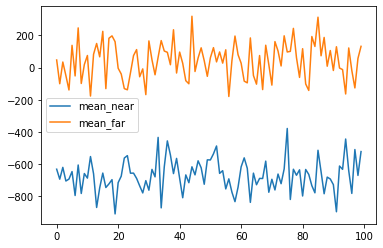

In [26]:
df_ttest[['mean_near','mean_far']].plot()

## Inner vs outter periphery for > 30 min to mass public transport

In [27]:
sample = 50
gdf_far_inner = hex_merge_peri[(hex_merge_peri.time_transporte_masivo_V2>30)&
                       (hex_merge_peri.Periferico==1)].sample(n=sample)
gdf_far_outter = hex_merge_peri[(hex_merge_peri.time_transporte_masivo_V2>30)&
                       (hex_merge_peri.Periferico==0)].sample(n=sample)

In [28]:
print("Promedio de cambio de población por distancia a transporte público masivo")
print(f"Más de 30 minutos fuera de periférico: {gdf_far_outter.T_Pob_10_20.mean()} personas")
print(f"Más de 30 minutos dentro de periférico: {gdf_far_inner.T_Pob_10_20.mean()} personas")

Promedio de cambio de población por distancia a transporte público masivo
Más de 30 minutos fuera de periférico: 1094.6 personas
Más de 30 minutos dentro de periférico: -147.58 personas


In [29]:
box_plot_tp_analysis = gdf_far_inner.copy()
box_plot_tp_analysis['periferico'] = 'Dentro de periférico'
box_plot_tp_analysis = box_plot_tp_analysis.append(gdf_far_outter)
idx = box_plot_tp_analysis['periferico'].isna()
box_plot_tp_analysis.loc[idx, 'periferico'] = 'Fuera de periférico'

Text(0, 0.5, 'Cambio en la población (2010 vs 2020)')

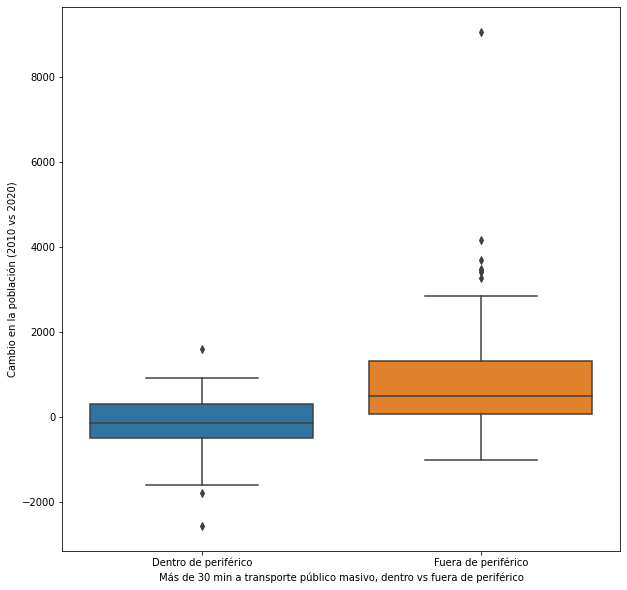

In [30]:
gdf_nearfig, ax = plt.subplots(figsize=(10,10))

x = np.array(box_plot_tp_analysis.periferico)
y = np.array(box_plot_tp_analysis.T_Pob_10_20)

sns.boxplot(x=x , y=y, ax=ax)

plt.xlabel('Más de 30 min a transporte público masivo, dentro vs fuera de periférico')
plt.ylabel('Cambio en la población (2010 vs 2020)')

In [31]:
stats.ttest_ind(gdf_far_inner.T_Pob_10_20, gdf_far_outter.T_Pob_10_20)

Ttest_indResult(statistic=-4.770990948030626, pvalue=6.396764733152454e-06)

In [32]:
dict_tmp = {}

for i in range(100):
    sample = 50
    gdf_far_inner = hex_merge_peri[(hex_merge_peri.time_transporte_masivo_V2>30)&
                           (hex_merge_peri.Periferico==1)].sample(n=sample)
    gdf_far_outter = hex_merge_peri[(hex_merge_peri.time_transporte_masivo_V2>30)&
                           (hex_merge_peri.Periferico==0)].sample(n=sample)
    
    _, pvalue = stats.ttest_ind(gdf_far_inner.T_Pob_10_20, gdf_far_outter.T_Pob_10_20)
    
    dict_tmp[i] = {'mean_inner':gdf_far_inner.T_Pob_10_20.mean(),
                  'mean_outter':gdf_far_outter.T_Pob_10_20.mean(),
                  'pvalue':pvalue}

In [33]:
df_ttest = pd.DataFrame.from_dict(dict_tmp).transpose()
print(df_ttest.shape)
df_ttest.head(2)

(100, 3)


,mean_inner,mean_outter,pvalue
0,-16.66,976.08,0.000055
1,35.50,1059.66,0.000031


In [34]:
idx = df_ttest.pvalue > 0.025
df_ttest[idx]

,mean_inner,mean_outter,pvalue
20,307.40,1037.66,0.067480
56,260.42,688.46,0.041676
60,207.62,804.18,0.077013
74,270.80,633.28,0.094787


In [35]:
idx = df_ttest.mean_inner > df_ttest.mean_outter
df_ttest[idx]

,mean_inner,mean_outter,pvalue


### Population change for iteratons

<AxesSubplot:>

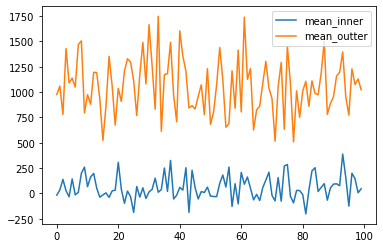

In [36]:
df_ttest[['mean_inner','mean_outter']].plot()

## Distance vs population change

In [37]:
x = np.array(hex_merge_peri.time_transporte_masivo_V2)
y = np.array(hex_merge_peri.T_Pob_10_20)
np.corrcoef(x, y)

array([[1.        , 0.16153879],
       [0.16153879, 1.        ]])

### Scatter - density plot

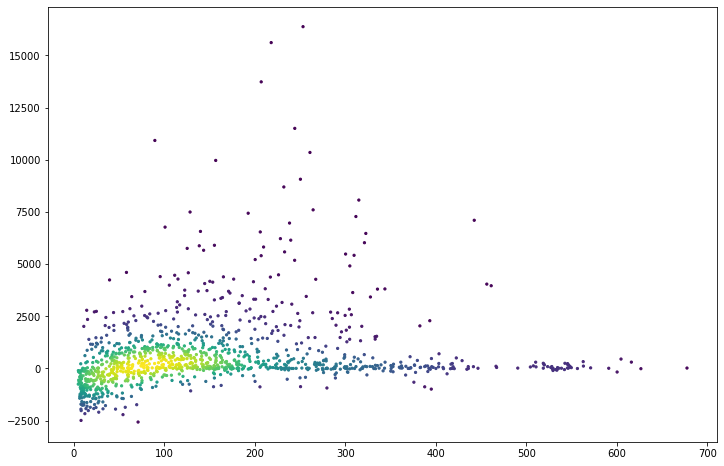

In [38]:

fig, ax = plt.subplots(figsize=(12,8))


# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

ax.scatter(x, y, c=z, s=5)
plt.show()